In [1]:
from typing import List

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.gridspec import GridSpec
import scipy.signal
import scipy.ndimage
import scipy.stats
import pendulum

import scienceplots
plt.style.use("science")


# add the my_packages directory to sys.path before importing the modules
sys.path.append(r"C:\Users\tomas\phd2023\PROJECTS\TUHH_projects\SecondVisit")

from my_packages.constants import FieldComponents, FieldTypes, Orientations, ProbeTypes
from my_packages.auxiliary_plotting_functions.composite_plots import stack_figures
from my_packages.constants import FrequencyUnits

from process_scanner_measurements.sample_planes.io import SamplePlaneIO


from spectrum_analysis.signal_matrices.signal_matrix import SignalMatrix
from spectrum_analysis.signal3d_matrices.signal3dmatrix import Signal3dMatrix
from spectrum_analysis.feature_extraction.analyzer import SpectralAnalyzer
from spectrum_analysis.feature_extraction.analyzer_registry import RegistrySpectralAnalyzer

from sample_fitting.correlation.correlation_analysis import CorrelationAnalyzer
from sample_fitting.correlation.correlation_analysis_registries import CorrelationAnalysis_SamplePlaneR
from sample_fitting.correlation.variogram_analysis import VariogramAnalyzer

## How GPR works

A **Gaussian Process (GP) is a collection random variables, such any subset of these is normally distributed.** Therefore, chosen N sample points, the associated values are distributed as a multi-variate normal distribution. 

That is we can assume that the field in the observation points are realizations of N RVs that are normally distributed. However, these **RVs are not independent but linked via a correlation matrix**.

Indeed, a correlation matrix is fully determined by two properties: 

- mean
- correlation matrix

The mean is usually set to zero for simplicity (the data can easily be normalized). While the correlation matrix is usually set by choosing a kernel function (a common choice is the RBF) that depends only on the sample points - and not on the measured values.  

The definition of the correlation matrix properties, and therefore the kernel properties, is crucial for setting the properties of the surrogate model. **The kernel properties are usually controlled by hyperparameters that can be tuned during the fitting of the particular observed dataset**. 


This is why it is possible to view the *prior* gaussian regression samples, i.e. arrays of RV sampled together before any observed data. Note that if the kernel assigns high correlations to RV corresponding to points that “close”, then the sampled priors appear *smooth.*

## Kernel Properties and GP Priors

In [2]:
from sample_fitting.surrogate_model.GPR.gaussian_regression import (
    GaussianRegressionModel,
    GaussianRegressionModelConfig,
)
from sample_fitting.surrogate_model.GPR.kernel_manager import KernelManager
from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel as C

random_state = 999

# define kernels
def rbf_kernel(variance, length_scale, length_scale_bounds):
    return C(constant_value=variance, constant_value_bounds=(1e-3, 1)) * RBF(
        length_scale=length_scale, length_scale_bounds=length_scale_bounds
    )
    
configs = GaussianRegressionModelConfig(
    n_restarts_optimizer=9,
    kernel_base_function=rbf_kernel,
    kernel_kwargs={"length_scale": 1, "length_scale_bounds": (1e-3, 1)},
    kernel_non_normalize_hyperparams={"variance": 0.5}
)
    
    
gpm = GaussianRegressionModel(
    configs=configs,
    random_state=random_state,
)

Unknown parameter random_state with value 999: ignoring.


We have now defined a kernel as the product of a constant component and the RBF function. The RBF function is defined as: 

$k(x, x') = \exp\left(-\frac{d(x, x')^2}{2l^2}\right)$

Let's inspect the shape of the rbf kernel function in 1d and how the hyper-parameters affect the shape.

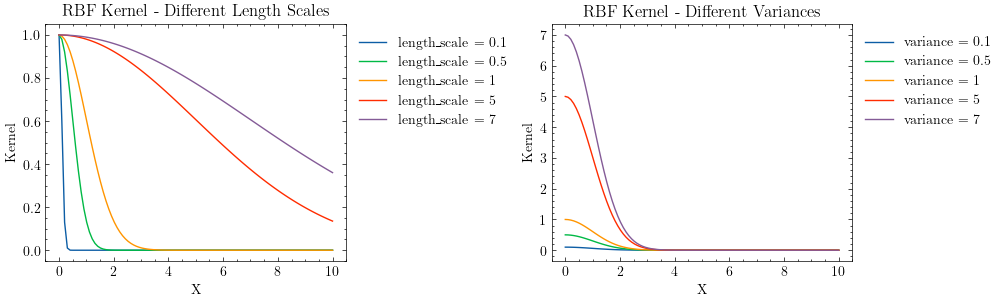

In [3]:


fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

kernels = []
for length_scale in [0.1, 0.5, 1, 5, 7]:
    rbfKii = rbf_kernel(1, length_scale, (1e-3, 1))
    kernels.append(rbfKii)
    
points = np.linspace(0, 10, 100).reshape(-1, 1)

gpm.plot_kernel_functions(kernels, X=points, ax=ax)
# change the legend labels
ax.legend(
    ["length_scale = {}".format(length_scale) for length_scale in [0.1, 0.5, 1, 5, 7]],
    loc="upper left",
    bbox_to_anchor=(1., 1),
    )
ax.set_title("RBF Kernel - Different Length Scales")

kernels = []
for variance in [0.1, 0.5, 1, 5, 7]:
    rbfKii = rbf_kernel(variance, 1, (1e-3, 1))
    kernels.append(rbfKii)

gpm.plot_kernel_functions(kernels, X=points, ax=ax1)
# change the legend labels
ax1.legend(
    ["variance = {}".format(variance) for variance in [0.1, 0.5, 1, 5, 7]],
    loc="upper left",
    bbox_to_anchor=(1., 1),
    )
ax1.set_title("RBF Kernel - Different Variances");

It can be seen that the length scale influences the smoothness of the rbf shape. A lower length scale allows the RBF function to change more freely. Instead, larger values of the constant kernel increase the variance at X=0. This parameter is introduced to add stability to the surrogate model. Indeed, it allows the GPR to adjust to changing variances of the fields in different regions. This is useful to capture wider dynamic ranges that are not known a priori. 

Now we can try extracting some samples from a GPR defined with zero mean and the correlation matrix. 

Unknown parameter random_state with value 999: ignoring.


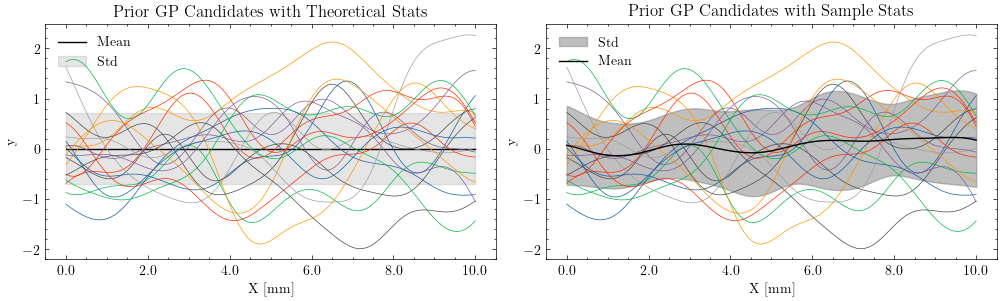

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

gpm = GaussianRegressionModel(
    configs=configs,
)

# the default units are mm, so let's rescale the points to be mm
points = np.linspace(0, 10, 100).reshape(-1, 1)*1e-3

gpm.plot_prior_gp_candidates_with_theoretical_stats(
    X=points, n_samples=20, random_state=random_state, ax=ax[0]
)

gpm.plot_prior_gp_candidates_with_sample_stats(
    X=points, n_samples=20, random_state=random_state, ax=ax[1]
)

ax[0].set_title("Prior GP Candidates with Theoretical Stats")
ax[1].set_title("Prior GP Candidates with Sample Stats");

Let's see what happens to the prior when we change the length scales or the constant value of the C kernel.

Unknown parameter random_state with value 999: ignoring.
Unknown parameter random_state with value 999: ignoring.
Unknown parameter random_state with value 999: ignoring.
Unknown parameter random_state with value 999: ignoring.


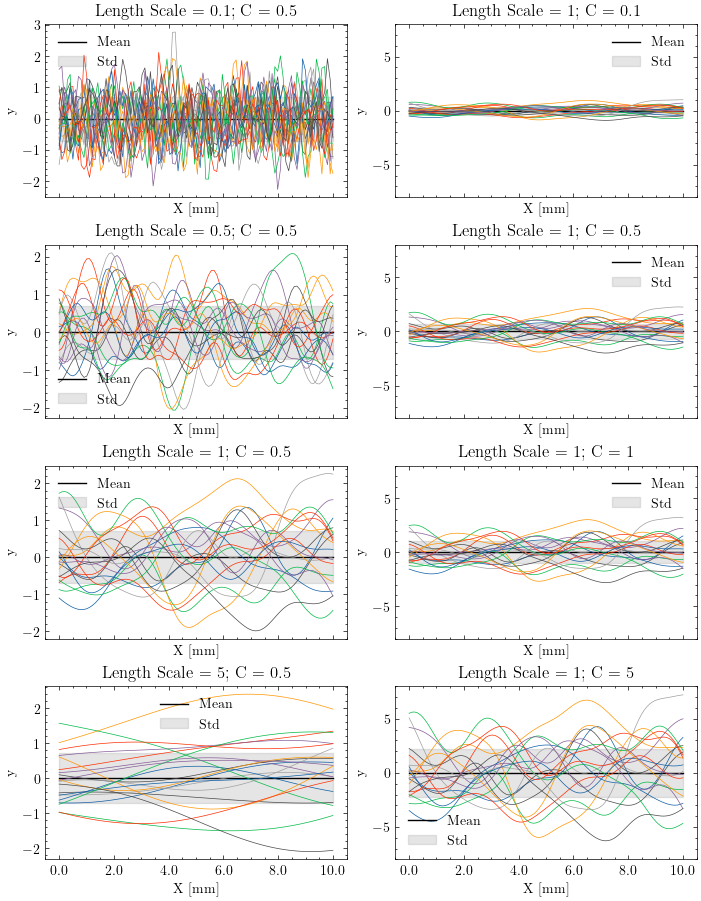

In [5]:
fig, ax = plt.subplots(4, 2, figsize=(7, 9), constrained_layout=True, sharex=True)

for i, length_scale in enumerate([0.1, 0.5, 1, 5]):
    gpm = GaussianRegressionModel(
        kernel_base_function=rbf_kernel,
        kernel_kwargs={"length_scale": length_scale, "length_scale_bounds": (1e-3, 1)},
        kernel_non_normalize_hyperparams={"variance": 0.5},
    )
    gpm.plot_prior_gp_candidates_with_theoretical_stats(
        X=points, n_samples=20, random_state=random_state, ax=ax[i, 0]
    )
    ax[i, 0].set_title("Length Scale = {}; C = 0.5".format(length_scale))

for i, variance in enumerate([0.1, 0.5, 1, 5]):
    gpm = GaussianRegressionModel(
        kernel_base_function=rbf_kernel,
        kernel_kwargs={"length_scale": 1, "length_scale_bounds": (1e-3, 1)},
        kernel_non_normalize_hyperparams={"variance": variance},
    )
    gpm.plot_prior_gp_candidates_with_theoretical_stats(
        X=points, n_samples=20, random_state=random_state, ax=ax[i, 1]
    )
    ax[i, 1].set_title("Length Scale = 1; C = {}".format(variance))
    ax[i, 1].set_ylim(-8, 8)


Although the length scale has a clear effect on the sample GPs, **the length scale has no effect on the mean or std of the prior**. On the other hand the constant kernel value C, **has a direct effect on the prior variance**. It follows that if we expect the fields to have larger dynamic range we should increase C. 

We can also inspec the GP priors over a 2d grid. Indeed, these 2d are the kind of GPs we will use for the surrogate model. 

Unknown parameter random_state with value 999: ignoring.


Text(0.5, 0.98, '2D Prior GP Candidates - kernel: 0.707**2 * RBF(length_scale=0.333)')

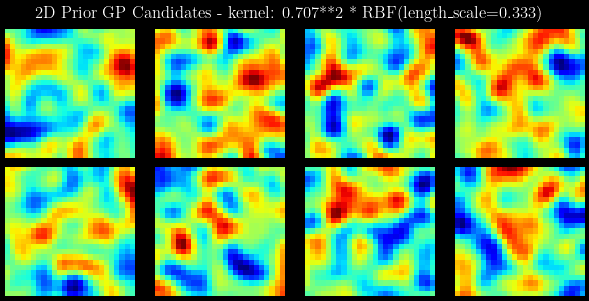

In [6]:
gpm = GaussianRegressionModel(
    kernel_base_function=rbf_kernel,
    kernel_kwargs={"length_scale": 1, "length_scale_bounds": (1e-3, 1)},
    kernel_non_normalize_hyperparams={"variance": 0.5},
    random_state=random_state,
)

axis = np.linspace(0, 10, 25)*1e-3
fig, ax = gpm.plot_prior_gp_2d(
    x_axis=axis, y_axis=axis, n_samples=8, 
    random_state=random_state, figsize=(6,3), 
    figs_per_row=4, artistic=True
);
fig.suptitle(f"2D Prior GP Candidates - kernel: {gpm.gp.kernel}", fontsize=12, color="white")

Unknown parameter random_state with value 999: ignoring.


Unknown parameter random_state with value 999: ignoring.
Unknown parameter random_state with value 999: ignoring.
Unknown parameter random_state with value 999: ignoring.


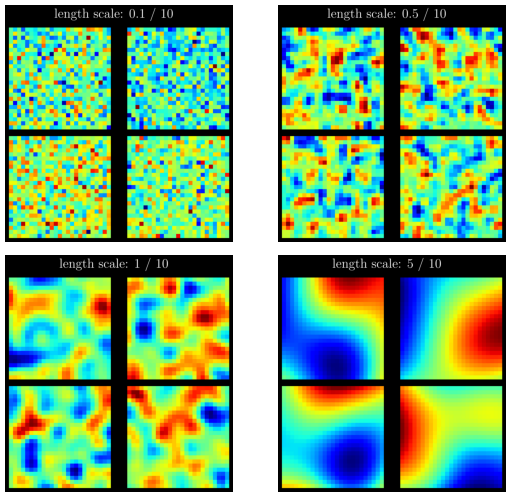

In [7]:
figures = []
for length_scale in [0.1, 0.5, 1, 5]:
    gpm = GaussianRegressionModel(
        kernel_base_function=rbf_kernel,
        kernel_kwargs={"length_scale": length_scale, "length_scale_bounds": (1e-3, 1)},
        kernel_non_normalize_hyperparams={"variance": 0.5},
        random_state=random_state,
    )
    fig, ax = gpm.plot_prior_gp_2d(
        x_axis=axis, y_axis=axis, n_samples=4, 
        random_state=random_state, figsize=(3,3), 
        figs_per_row=2, artistic=True
    )
    fig.suptitle(f"length scale: {length_scale} / 10", fontsize=12, color="white")
    figures.append(fig) 

# figA, _ = stack_figures(figures[:2], figshape="row", figsize=(6, 3))
# figB, _ = stack_figures(figures[2:], figshape="row", figsize=(6, 3))

# fig = stack_figures([figA, figB], figshape="column", figsize=(6, 6))

fig, ax = stack_figures(figures, figshape=(2, 2), figsize=(5, 5), aspect="equal")

By inspecting the GP priors, the following idea comes to mind. The field plots obtained seem very similar to the field plots generated by random arrays of dipoles. If it is possible to obtain a relationship between the dipole array characteristics and the GP priors. Then, by optimizing the surrogate model to fit the data, we already know the dipole resolution and spacing for the IDM. 

In any case field scans at different heights should be modeled with different length scales. 

# Introduce 1d targets

Now let's consider a 1d process that we want to model. Following the example code of https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html.

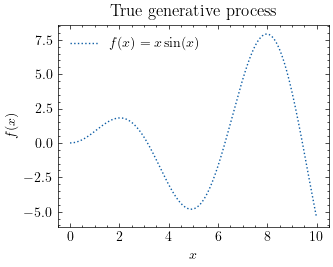

In [8]:
X = np.linspace(start=0, stop=10, num=1_000)
y = X * np.sin(X)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process");

Next we select 6 datapoints

In [9]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

First let's see how the gpm fitting works. You can inspect the kernel passed to the gp, by looking for: 

`gpm.gp.kernel`

And the optimized kernel by inspecting: 

`gpm.gp.kernel_`

Alternatively, you can use the function: `gpm.get_kernel_params()` to see the optimized parameters. Indeed, by using this method the parameters are inverse transformed by the Scaler, so the results you obtain are directly comparable to the data.  

The gdm class automatically normalizes the training data X (by default normalized with standard normalization). This has been shown to improve the robustness of solutions.
Note that it is necessary to pass the kernel in the form of a function and the kwargs in two dictionaries. This is because `kernel_kwargs` are rescaled in the same way as the training data. 

In [10]:
# define kernels
def rbf_kernel(variance, length_scale, length_scale_bounds):
    return C(constant_value=variance, constant_value_bounds=(1e-3, 10)) * RBF(
        length_scale=length_scale, length_scale_bounds=length_scale_bounds
    )


gpm = GaussianRegressionModel(
    kernel_base_function=rbf_kernel,
    kernel_kwargs={"length_scale": 1, "length_scale_bounds": (1e-3, 10)},
    kernel_non_normalize_hyperparams={"variance": 0.5},
    random_state=random_state,
    units = "m",
    n_restarts_optimizer=0,
)

gpm.fit(X_train.reshape(-1, 1), y_train)
gpm.get_kernel_params()

Unknown parameter random_state with value 999: ignoring.


{'constant_value': 0.6031014180321992,
 'length_scales': array([1.84219215]),
 'length_scale_bounds': array([[1.e-03, 1.e+01]])}

Note that although we set the number of restarts to 0, the optimized values of the kernel params are still different from the ones we passed. This is because this initial run is still performed. If you don't want any optimization done, then you should pass the optimizer = None kwarg to the `fit` method. 

Alternatively, if you want to exclude the some kernel parameter from optimization, set the bounds to "fixed". 

In [11]:
## Alternatively, maybe I want to only optimize the length scale
def rbf_kernel(constant, constant_bounds, length_scale, length_scale_bounds):
    return C(constant_value=constant, constant_value_bounds=constant_bounds) * RBF(
        length_scale=length_scale, length_scale_bounds=length_scale_bounds
    )

gpm = GaussianRegressionModel(
    kernel_base_function=rbf_kernel,
    kernel_kwargs={"length_scale": 1, "length_scale_bounds": (1e-3, 10)},
    kernel_non_normalize_hyperparams={
        "constant": 0.5,
        "constant_bounds": "fixed",
    },
    random_state=random_state,
    units="m",
    n_restarts_optimizer=0,
)
gpm.fit(X_train.reshape(-1, 1), y_train, optimizer=None)

print("No Optimization")
print("initial kernel: ", gpm.gp.kernel)
print("optimized kernel: ", gpm.gp.kernel_)

gpm.fit(X_train.reshape(-1, 1), y_train)

print("Fixed Constant")
print("initial kernel: ", gpm.gp.kernel)
print("optimized kernel: ", gpm.gp.kernel_)

gpm.update_kernel(
    base_kernel=rbf_kernel,
    length_scale = 1,
    length_scale_bounds="fixed",
    non_normalize_hyperparams={
        "constant": 0.5,
        "constant_bounds": (1e-3, 10),
    },
)
gpm.fit(X_train.reshape(-1, 1), y_train)

print("Fixed Length Scale")
print("initial kernel: ", gpm.gp.kernel)
print("optimized kernel: ", gpm.gp.kernel_)

Unknown parameter random_state with value 999: ignoring.


No Optimization
initial kernel:  0.707**2 * RBF(length_scale=0.411)
optimized kernel:  0.707**2 * RBF(length_scale=0.411)
Fixed Constant
initial kernel:  0.707**2 * RBF(length_scale=0.411)
optimized kernel:  0.707**2 * RBF(length_scale=0.805)
Fixed Length Scale
initial kernel:  0.707**2 * RBF(length_scale=0.411)
optimized kernel:  0.46**2 * RBF(length_scale=0.411)


Now let's fit the with the datapoints we have and allow for optimization of the kernel parameters

Unknown parameter random_state with value 999: ignoring.


initial kernel:  0.707**2 * RBF(length_scale=0.411)
optimized kernel:  0.603**2 * RBF(length_scale=0.757)


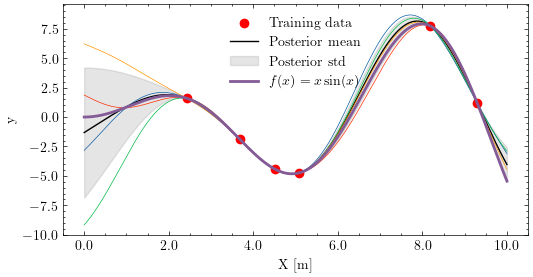

In [12]:
def rbf_kernel(constant, constant_bounds, length_scale, length_scale_bounds):
    return C(constant_value=constant, constant_value_bounds=constant_bounds) * RBF(
        length_scale=length_scale, length_scale_bounds=length_scale_bounds
    )


gpm = GaussianRegressionModel(
    kernel_base_function=rbf_kernel,
    kernel_kwargs={"length_scale": 1, "length_scale_bounds": (1e-3, 10)},
    kernel_non_normalize_hyperparams={
        "constant": 0.5,
        "constant_bounds": (1e-3, 10),
    },
    random_state=random_state,
    units="m",
    n_restarts_optimizer=10,
)

gpm.fit(X_train.reshape(-1, 1), y_train)

fig, ax = gpm.plot_candidates_with_theoretical_stats(
    X=X, n_samples=4, random_state=random_state, figsize=(6, 3)
)

ax.plot(X, y, label=r"$f(x) = x \sin(x)$", linewidth=2)
ax.legend()

print("initial kernel: ", gpm.gp.kernel)
print("optimized kernel: ", gpm.gp.kernel_)

Now let's inspect the effect of changing the kernel parameters and not optimizing. 

The gpm class automatically normalizes the labels with MinMaxScaler. Therefore, the median value will always be 0.5. This is a good value to set to the constant kernel.

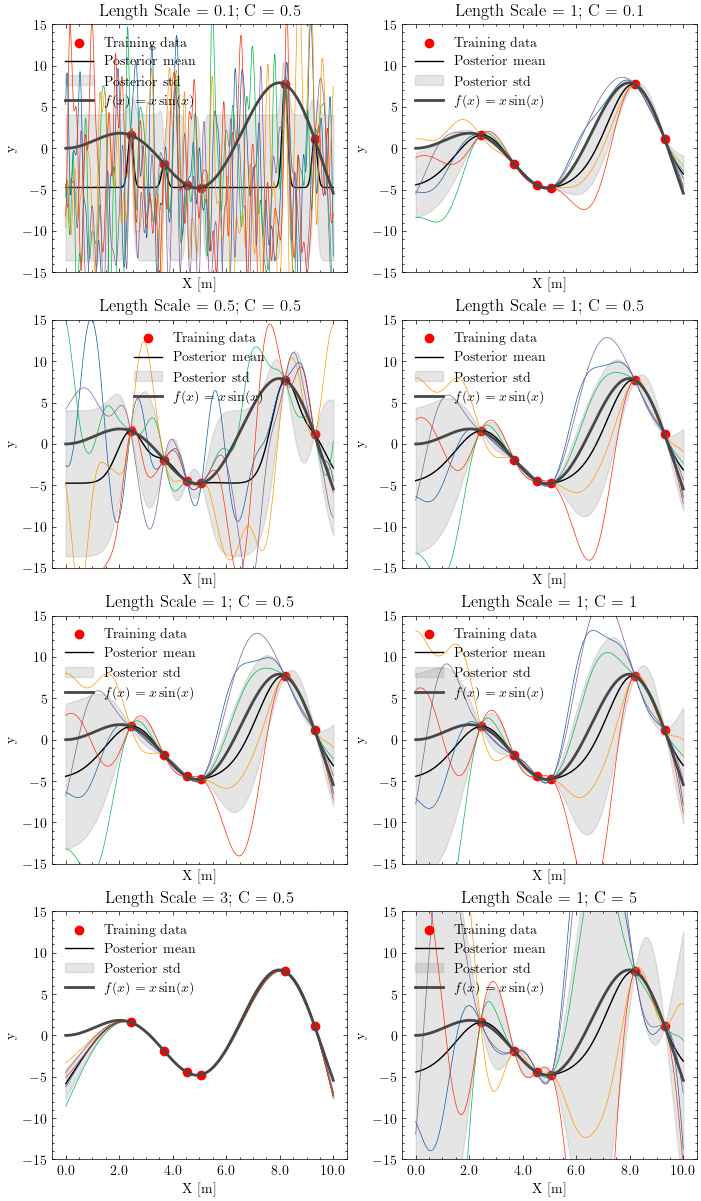

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(7, 12), constrained_layout=True, sharex=True)

def_hyperparams = {
    "length_scale": 1,
    "length_scale_bounds": "fixed",
}

def_non_normalize_hyperparams = {
    "constant": 0.5,
    "constant_bounds": "fixed",
}

gpm = GaussianRegressionModel(
    kernel_base_function=rbf_kernel,
    kernel_kwargs=def_hyperparams,
    kernel_non_normalize_hyperparams=def_non_normalize_hyperparams,
    units="m",
    n_restarts_optimizer=10,
)

for i, length_scale in enumerate([0.1, 0.5, 1, 3]):
    gpm.update_kernel(
        base_kernel=rbf_kernel,
        length_scale=length_scale,
        length_scale_bounds="fixed",
        non_normalize_hyperparams=def_non_normalize_hyperparams
    )
    gpm.fit(X_train.reshape(-1, 1), y_train)
    
    gpm.plot_candidates_with_theoretical_stats(
        X=X, n_samples=5, random_state=random_state, ax=ax[i, 0]
    )
    ax[i, 0].set_title("Length Scale = {}; C = 0.5".format(length_scale))

for i, constant in enumerate([0.1, 0.5, 1, 5]):
    gpm.update_kernel(
        base_kernel=rbf_kernel,
        non_normalize_hyperparams={
            "constant": constant,
            "constant_bounds": "fixed",
        },
        **def_hyperparams,
    )
    gpm.fit(X_train.reshape(-1, 1), y_train)
    gpm.plot_candidates_with_theoretical_stats(
        X=X, n_samples=5, random_state=random_state, ax=ax[i, 1]
    )
    ax[i, 1].set_title("Length Scale = 1; C = {}".format(constant))


for axx in ax.flatten():
    axx.set_ylim(-15, 15)
    # plot the original function
    axx.plot(X, y, label=r"$f(x) = x \sin(x)$", linewidth=2)
    axx.legend()
    

Now let's see the effect of introducing an alpha parameter: **This can be interpreted as the variance of white gaussian noise.**

In [14]:
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

alpha = noise_std ** 2

Note that this interpretation of alpha is based on the label values. However, the labels are normalized using MinMaxScaler in the class. Therefore, in order to apply this logic to the class the value of alpha should be rescaled: 

$\alpha_{rescaled} = \alpha \cdot \text{scaler.scale\_}^2$

The square operation is necessary because alpha is related to the variance. 

By default the `rescale_alpha` option in the fit method of the class is set to False. Indeed, it is usually more helpful to set a regularization alpha term ignoring the specific scale of the inputs. 

initial kernel:  0.707**2 * RBF(length_scale=0.411)
optimized kernel:  0.651**2 * RBF(length_scale=0.724)
{'constant_value': 0.6511111033477661, 'length_scales': array([1.76203731]), 'length_scale_bounds': array([[1.e-03, 1.e+01]])}


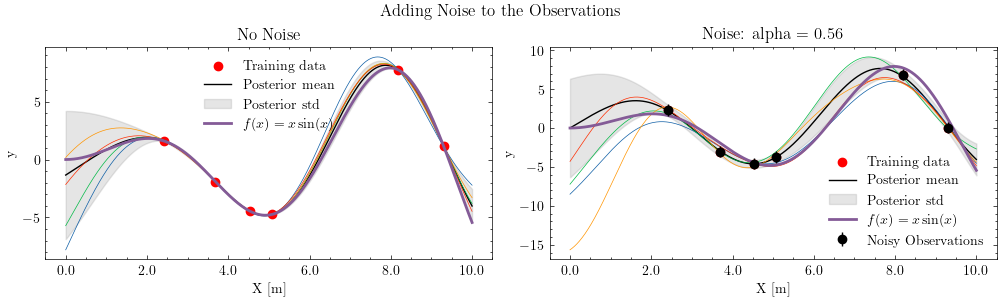

In [15]:
gpm = GaussianRegressionModel(
    kernel_base_function=rbf_kernel,
    kernel_kwargs={
        "length_scale": 1,
        "length_scale_bounds": (1e-3, 10),
        },
    kernel_non_normalize_hyperparams={
        "constant": 0.5,
        "constant_bounds": (1e-3, 10),
    },
    units="m",
    n_restarts_optimizer=10,
    alpha = 1e-5
)

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

gpm.fit(X_train.reshape(-1, 1), y_train)
gpm.plot_candidates_with_theoretical_stats(X, ax = ax[0])
ax[0].set_title("No Noise")

gpm.update_configs_properties(alpha=alpha)
gpm.fit(X_train.reshape(-1, 1), y_train_noisy, rescale_alpha=True)
gpm.plot_candidates_with_theoretical_stats(X, ax=ax[1])
ax[1].set_title(f"Noise: alpha = {alpha:.2f}")

for axx in ax:     
    axx.plot(X, y, label=r"$f(x) = x \sin(x)$", linewidth=2)

ax[1].errorbar(X_train, y_train_noisy, yerr=noise_std, fmt="o", color="black", label="Noisy Observations")

for axx in ax:
    axx.legend()
    
fig.suptitle("Adding Noise to the Observations")

print("initial kernel: ", gpm.gp.kernel)
print("optimized kernel: ", gpm.gp.kernel_)

print(gpm.get_kernel_params())

## The Matern Kernel

**Matern kernel** is defined as: 

$K_\nu(x, x') = \frac{2^{1-\nu}}{\Gamma(\nu)}\left(\frac{\sqrt{2\nu}\|x - x'\|}{l}\right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\|x - x'\|}{l}\right)$

- *Kν* is a modified Bessel function.
- Γ is the gamma function.
- *ν* is a positive parameter controlling the smoothness of the function; larger values lead to smoother functions.
- *l* is the length scale parameter.
- ∥*x*−*x*′∥ is the Euclidean distance between the input vectors *x* and *x*′.

This kernel is a generalization of the RBF: indeed, it becomes equivalent to the RBF kernel as *ν* approaches infinity. But the parameter $\nu$ controls the level of *smoothness* of the functions. For example $\nu=3/2$, it becomes continuous of the first order, 5/2 of the second order and so on (we set $\nu=1.5$).

In [16]:
# define kernels
def rbf_kernel(constant, length_scale, length_scale_bounds="fixed", constant_value_bounds="fixed"):
    return C(constant_value=constant, constant_value_bounds=constant_value_bounds) * RBF(
        length_scale=length_scale, length_scale_bounds=length_scale_bounds
    )


def matern_kernel(constant, length_scale, nu, constant_value_bounds="fixed", length_scale_bounds="fixed"):
    return C(constant_value=constant, constant_value_bounds=constant_value_bounds) * Matern(
        length_scale=length_scale, length_scale_bounds=length_scale_bounds, nu=nu
    )

comparing the Matern Kernel with the RBF kernel, we can see that incresing nu makes the Matern kernel converge to the RBF:

Text(0.5, 1.0, 'Matern Kernel - Different Nu')

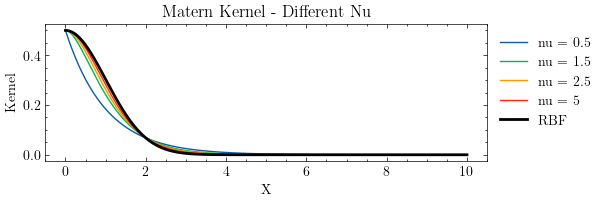

In [17]:
fig, ax  = plt.subplots(figsize=(6, 2), constrained_layout=True)

kernel_rbf = rbf_kernel(
    constant=0.5,
    length_scale=1,
)

matern_kernels = []
for ii, nu in enumerate([0.5, 1.5, 2.5, 5]):
    kernel_m = matern_kernel(
        constant=0.5,
        length_scale=1,
        nu=nu,
    )
    matern_kernels.append(kernel_m)

gpm.plot_kernel_functions(matern_kernels, X=X.reshape(-1, 1), ax=ax)
gpm.plot_kernel_functions([kernel_rbf], X=X.reshape(-1, 1), ax=ax, linewidth=2, color="black")
ax.legend(
    [r"nu = {}".format(nu) for nu in [0.5, 1.5, 2.5, 5]] + ["RBF"],
    loc="upper left",
    bbox_to_anchor=(1.0, 1),
)

ax.set_title("Matern Kernel - Different Nu");

Now let's compare the priors. 

**NOTE: make sure to add the $\nu$ parameter among the `non_normalize_hyperparameters`**

Text(0.5, 0.98, 'Prior GP Candidates with Theoretical Stats')

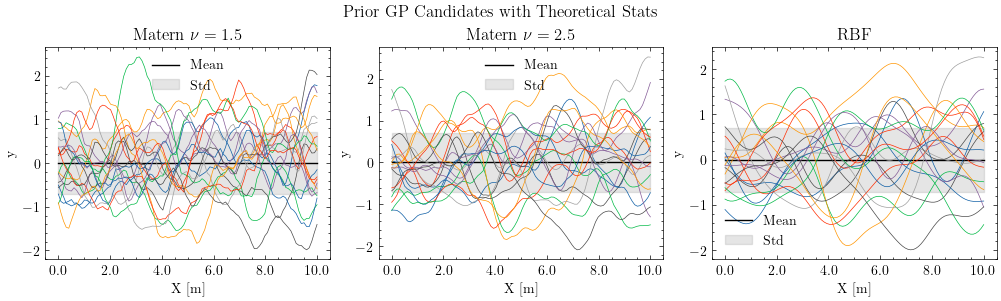

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)

length_scale = 1
constant = 0.5
nu1 = 1.5
nu2 = 2.5

gpm_matern = GaussianRegressionModel(
    kernel_base_function=matern_kernel,
    kernel_kwargs={"length_scale": length_scale},
    kernel_non_normalize_hyperparams={"constant": constant, "nu": nu1},
    units="m",
)

gpm_rbf = GaussianRegressionModel(
    kernel_base_function=rbf_kernel,
    kernel_kwargs={"length_scale": length_scale},
    kernel_non_normalize_hyperparams={"constant": constant},
    units="m",
)


# the default units are mm, so let's rescale the points to be mm
points = np.linspace(0, 10, 100).reshape(-1, 1)


gpm_matern.plot_prior_gp_candidates_with_theoretical_stats(
    X=points, n_samples=20, random_state=random_state, ax=ax[0]
)

gpm_matern.update_kernel(
    base_kernel=matern_kernel,
    length_scale=length_scale,
    length_scale_bounds="fixed",
    non_normalize_hyperparams={"constant": constant, "nu": nu2},
    )

gpm_matern.plot_prior_gp_candidates_with_theoretical_stats(
    X=points, n_samples=20, random_state=random_state, ax=ax[1]
)


gpm_rbf.plot_prior_gp_candidates_with_theoretical_stats(
    X=points, n_samples=20, random_state=random_state, ax=ax[2]
)

ax[0].set_title(r"Matern $\nu = 1.5$")
ax[1].set_title(r"Matern $\nu = 2.5$")
ax[2].set_title("RBF")

fig.suptitle("Prior GP Candidates with Theoretical Stats")

It can be seen that the theoretical prior assumptions remain the same: zero mean and $\text{Var} = 0.5^2$. However, it can be seen that the $\nu$ parameter impacts the smoothness of the GP candidates, converging to the RBF at the limit. 

It can be useful to use this kernel if the field that is being modelled exhibits some sharp changes or jumps.

We can inspect the behavior of the priors in 2D:

Text(0.5, 1.05, '2D Prior GP Candidates - length scale = 1.5')

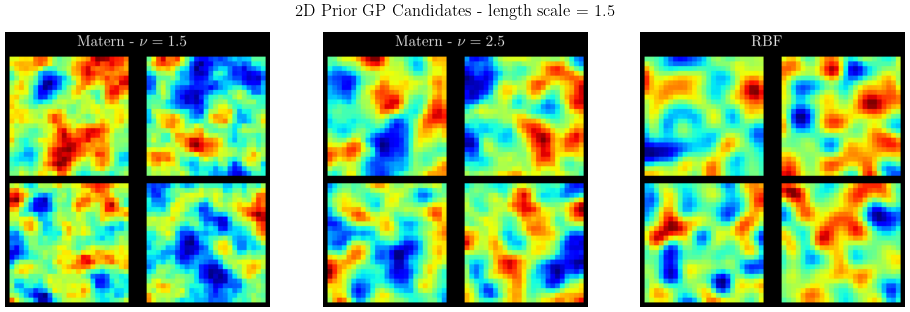

In [19]:
axis = np.linspace(0, 10, 25)

length_scale=1.5

gpm_matern.update_kernel(
    base_kernel=matern_kernel,
    length_scale=length_scale,
    length_scale_bounds="fixed",
    non_normalize_hyperparams={"constant": constant, "nu": nu1},
)

fig_nu1, ax = gpm_matern.plot_prior_gp_2d(
    x_axis=axis,
    y_axis=axis,
    n_samples=4,
    random_state=random_state,
    figsize=(3, 3),
    figs_per_row=2,
    artistic=True,
)
fig_nu1.suptitle(fr"Matern - $\nu={nu1}$", fontsize=12, color="white")


gpm_matern.update_kernel(
    base_kernel=matern_kernel,
    length_scale=length_scale,
    length_scale_bounds="fixed",
    non_normalize_hyperparams={"constant": constant, "nu": nu2},
)


fig_nu2, ax = gpm_matern.plot_prior_gp_2d(
    x_axis=axis,
    y_axis=axis,
    n_samples=4,
    random_state=random_state,
    figsize=(3, 3),
    figs_per_row=2,
    artistic=True,
)

fig_nu2.suptitle(fr"Matern - $\nu={nu2}$", fontsize=12, color="white")

fig_rbf, ax = gpm_rbf.plot_prior_gp_2d(
    x_axis=axis,
    y_axis=axis,
    n_samples=4,
    random_state=random_state,
    figsize=(3, 3),
    figs_per_row=2,
    artistic=True,
)

fig_rbf.suptitle("RBF", fontsize=12, color="white")

fig, ax = stack_figures([fig_nu1, fig_nu2, fig_rbf], figshape=(1, 3), figsize=(9, 3), aspect="equal")

fig.suptitle(f"2D Prior GP Candidates - length scale = {length_scale}", fontsize=12, color="black", y=1.05)

## Let's know inspect the Posterior

initial kernel:  0.707**2 * Matern(length_scale=0.411, nu=1.5)
optimized kernel:  0.554**2 * Matern(length_scale=0.928, nu=1.5)


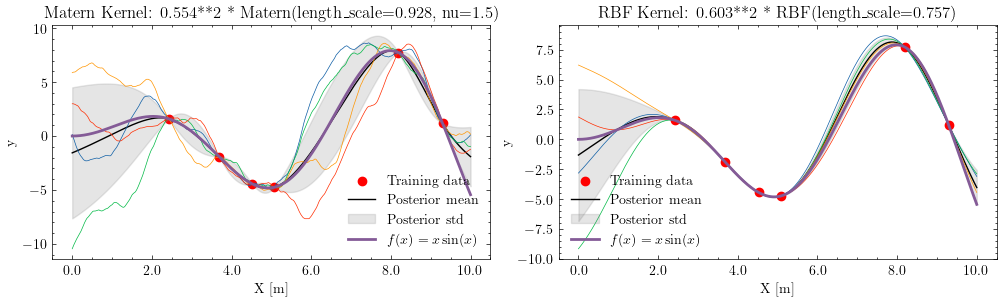

In [20]:
gpm_matern = GaussianRegressionModel(
    kernel_base_function=matern_kernel,
    kernel_kwargs={"length_scale": 1, "length_scale_bounds": (1e-3, 10)},
    kernel_non_normalize_hyperparams={
        "constant": 0.5,
        "constant_value_bounds": (1e-3, 10),
        "nu": 1.5,
    },
    units="m",
    n_restarts_optimizer=10,
    alpha=1e-10
)

gpm_rbf = GaussianRegressionModel(
    kernel_base_function=rbf_kernel,
    kernel_kwargs={"length_scale": 1, "length_scale_bounds": (1e-3, 10)},
    kernel_non_normalize_hyperparams={"constant": 0.5, "constant_value_bounds": (1e-3, 10)},
    units="m",
    n_restarts_optimizer=10,
    alpha=1e-10,
)


gpm_matern.fit(X_train.reshape(-1, 1), y_train)
gpm_rbf.fit(X_train.reshape(-1, 1), y_train)


fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

gpm_matern.plot_candidates_with_theoretical_stats(
    X=X, n_samples=4, random_state=random_state, ax=ax[0]
)

gpm_rbf.plot_candidates_with_theoretical_stats(
    X=X, n_samples=4, random_state=random_state, ax=ax[1]
)


for axx in ax:
    axx.plot(X, y, label=r"$f(x) = x \sin(x)$", linewidth=2)
    axx.legend()
    
ax[0].set_title(f"Matern Kernel: {gpm_matern.gp.kernel_}")
ax[1].set_title(f"RBF Kernel: {gpm_rbf.gp.kernel_}")


print("initial kernel: ", gpm_matern.gp.kernel)
print("optimized kernel: ", gpm_matern.gp.kernel_)

The extra degree of freedome afforded to the Matern Kernel by $\nu$ can be seen in the increased uncertainty in the Matern kernel prediction. Indeed, it seems that it is necessary to have many more samples to fit the Matern kernel wrt the RBF kernel. The flip side, is of course that the Matern Kernel is less likely to fail in finding a GP model, while the RBF kernel can easily be overfitted. 

While the individual GP sample are very different, the posterior means - that are what is commonly used as surrogate model - appear to be similar in the two cases. The most affected part is the variance. 

Let's compare the two posteriors with the same lenght scale and C hyperparameters. 

initial kernel:  0.707**2 * Matern(length_scale=0.411, nu=1.5)
optimized kernel:  0.707**2 * Matern(length_scale=0.411, nu=1.5)


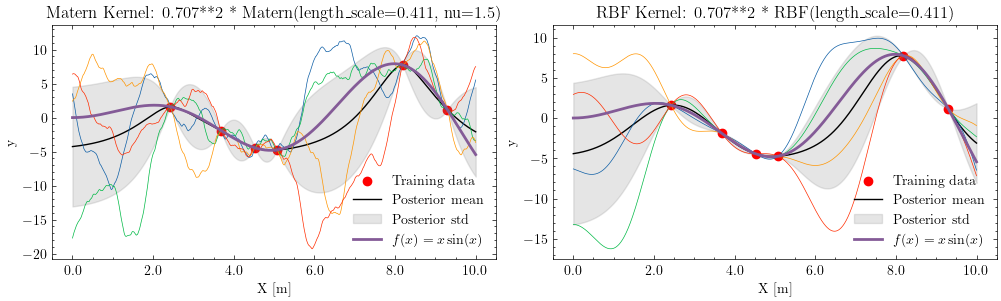

In [21]:
gpm_matern = GaussianRegressionModel(
    kernel_base_function=matern_kernel,
    kernel_kwargs={"length_scale": 1},
    kernel_non_normalize_hyperparams={
        "constant": 0.5,
        "nu": 1.5,
    },
    units="m",
    n_restarts_optimizer=10,
    alpha=1e-10,
)

gpm_rbf = GaussianRegressionModel(
    kernel_base_function=rbf_kernel,
    kernel_kwargs={"length_scale": 1},
    kernel_non_normalize_hyperparams={"constant": 0.5},
    units="m",
    n_restarts_optimizer=10,
    alpha=1e-10,
)


gpm_matern.fit(X_train.reshape(-1, 1), y_train)
gpm_rbf.fit(X_train.reshape(-1, 1), y_train)


fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

gpm_matern.plot_candidates_with_theoretical_stats(
    X=X, n_samples=4, random_state=random_state, ax=ax[0]
)

gpm_rbf.plot_candidates_with_theoretical_stats(
    X=X, n_samples=4, random_state=random_state, ax=ax[1]
)


for axx in ax:
    axx.plot(X, y, label=r"$f(x) = x \sin(x)$", linewidth=2)
    axx.legend()

ax[0].set_title(f"Matern Kernel: {gpm_matern.gp.kernel_}")
ax[1].set_title(f"RBF Kernel: {gpm_rbf.gp.kernel_}")


print("initial kernel: ", gpm_matern.gp.kernel)
print("optimized kernel: ", gpm_matern.gp.kernel_)

Let's see the effect of including an $\alpha$ parameter for noisy samples. 

initial kernel:  0.707**2 * Matern(length_scale=0.411, nu=1.5)
optimized kernel:  0.531**2 * Matern(length_scale=0.822, nu=1.5)
{'constant_value': 0.5314830121631451, 'length_scales': array([2.00056985]), 'length_scale_bounds': array([[1.e-03, 1.e+01]])}


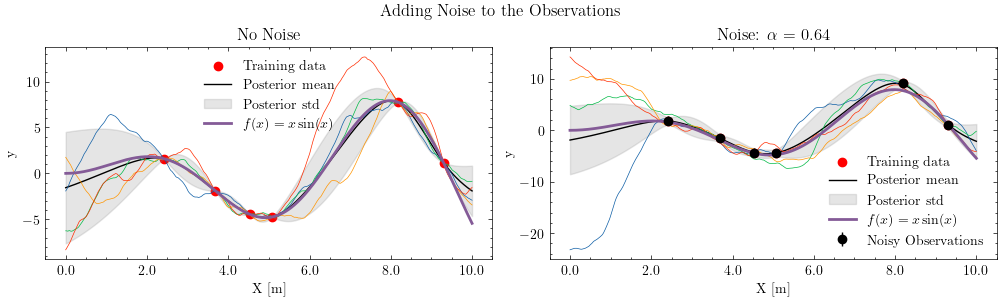

In [25]:
gpm_matern = GaussianRegressionModel(
    kernel_base_function=matern_kernel,
    kernel_kwargs={"length_scale": 1, "length_scale_bounds": (1e-3, 10)},
    kernel_non_normalize_hyperparams={
        "constant": 0.5,
        "constant_value_bounds": (1e-3, 10),
        "nu": 1.5,
    },
    units="m",
    n_restarts_optimizer=10,
    alpha=1e-10,
)


noise_std = 0.8
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

alpha = noise_std**2


fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

gpm_matern.fit(X_train.reshape(-1, 1), y_train)
gpm_matern.plot_candidates_with_theoretical_stats(X, ax=ax[0])
ax[0].set_title("No Noise")

gpm_matern.update_configs_properties(alpha=alpha)
gpm_matern.fit(X_train.reshape(-1, 1), y_train_noisy, rescale_alpha=True)
gpm_matern.plot_candidates_with_theoretical_stats(X, ax=ax[1])
ax[1].set_title(fr"Noise: $\alpha$ = {alpha:.2f}")

for axx in ax:
    axx.plot(X, y, label=r"$f(x) = x \sin(x)$", linewidth=2)

ax[1].errorbar(
    X_train, y_train_noisy, yerr=noise_std, fmt="o", color="black", label="Noisy Observations"
)

for axx in ax:
    axx.legend()

fig.suptitle("Adding Noise to the Observations")

print("initial kernel: ", gpm_matern.gp.kernel)
print("optimized kernel: ", gpm_matern.gp.kernel_)

print(gpm_matern.get_kernel_params())